In [791]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 8

import os
from pprint import pprint
from copy import deepcopy

# Investigtion into Cases of Dengue in the Philippines

## 1. Understanding and Applications

In [2]:
from IPython.display import Image
from IPython.core.display import HTML

Image(url='http://www.philippines-travel-guide.com/images/xpi-map.jpg.pagespeed.ic.PhvJv6GE2h.jpg')

This dataset contains information on 8 years of the cases of dengue fever in the Philippines. Dengue is a serious disease that spreads by way of mosquito and is extremely infectious, infecting between 50 and 100 million per year, [according to the CDC](https://www.cdc.gov/dengue/epidemiology/index.html) and killing 22,000, mostly children. One of the most heavily-affected areas in the world is the Philippines, which will deal with hundreds of thousands of cases per year, [many of which are children under 5, who suffer a nearly 90% fatality rate](http://www.doh.gov.ph/sites/default/files/statistics/DENGUE%20MW28.pdf).

Clearly, it would be beneficial to know how a particular year, or a particular month is goin to be for the disease, whether there won't be many cases, or if there will be a massive epidemic. This gives the Philippine Department of Health, as well as other government and non-government organizations a chance to prepare for a tiem period expected to be particularly bad. We will attempt to build an algorithm to predict this with Logistic Regression on past data, by region.

Since Logistic Regression is a classification, not a regression, algorithm, we will quantize the data, so that we are predicting for certain qualitative cutoffs of infection severity. As with any detection algorithm, it is much easier to handle cases where the predicted outcome is more severe than the actual outcome than it is to handle the inverse, so we will favor accuracy in predicting the more severe time periods over predicting less severe months and years. However, it is also important to correctly predict the low-severity years, so that the government retains its funding to use it efficiently on years where it is more important but less important than predicting high-severity times.

One simple, albeit arbitrary, heuristic which we will use as a baseline is to predict each month to be identical to the previous month. If our model adds information and helps to predict the future cases of the disease, it should be able to predict the relative severity of the disease better than this somewhat mindless baseline.

Source: [Kaggle: Dengue Cases in the Philippines](https://www.kaggle.com/grosvenpaul/dengue-cases-in-the-philippines)

## 2. Analysis

In [3]:
file_dir = os.path.join(os.pardir, 'data', 'denguecases.csv')

dengue_df = pd.read_csv(file_dir)
dengue_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1836 entries, 0 to 1835
Data columns (total 4 columns):
Month           1836 non-null object
Year            1836 non-null int64
Region          1836 non-null object
Dengue_Cases    1836 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 57.5+ KB


In [4]:
months = {'Jan': 1,
          'Feb': 2,
          'Mar': 3,
          'Apr': 4,
          'May': 5,
          'Jun': 6,
          'Jul': 7,
          'Aug': 8,
          'Sep': 9,
          'Oct': 10,
          'Nov': 11,
          'Dec': 12
         }

# want to convert months to 
def month_to_num(month):
    if month in months.keys():
        return months[month]
    else:
        return month

In [5]:
def group_heatmap(data, y_hat, group_feature, error=False):
    if 'Dengue_Cases' not in data.columns:
        data_m = data.filter(['Region', group_feature]).merge(pd.DataFrame(y_hat), right_index=True, left_index=True, sort=False)
    else:
        data_m = data.filter(['Region', group_feature, 'Dengue_Cases'], axis=1)
    groups = data_m.groupby([group_feature, 'Region'], sort=False)
    group_sum = groups.sum().unstack(level=0)
    sns.heatmap(group_sum, cmap='Reds')

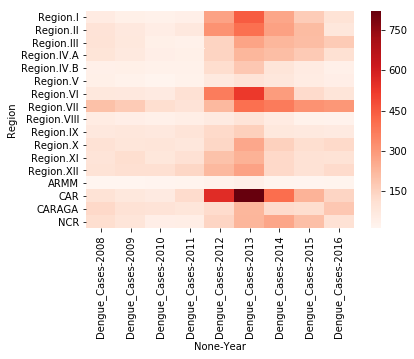

In [6]:
group_heatmap(dengue_df.drop('Dengue_Cases', axis=1), dengue_df.Dengue_Cases, 'Year')

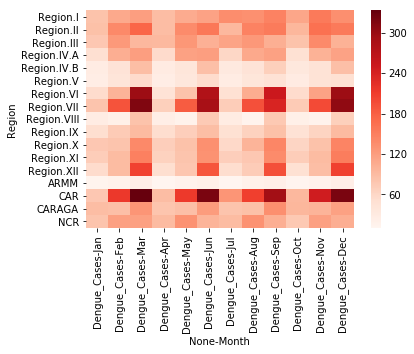

In [7]:
group_heatmap(dengue_df.drop('Dengue_Cases', axis=1), dengue_df.Dengue_Cases, 'Month')

This gives us an interesting view of what features may be important and which features we may need to engineer. Clearly, region is going to be important. Also, absolute month matters a lot, as there appears to be an extremely predictable four-season cycle of disease intensity.

Unlike months, however, the absolute year is unlikely to tell us much at all (What does 2008 data have to do with 2016 data?). However, we could do something like adding features for how many confirmed cases were in the year or two previous. Additionally, it may be useful to keep data on the past month or two. This may cause awkwardness around the start of the data, and we may have to decide whether to throw out the early data or just assume that any earlier data was 0 or the mean over years or some other standard setting.

In [8]:
# one-hot encode the Region and Month variables

dengue_one_hot = pd.concat([dengue_df.drop(['Region', 'Year', 'Month'], axis=1), # dropping year because it's unnecessary
                            pd.get_dummies(dengue_df.Region), 
                            pd.get_dummies(dengue_df.Month)],
                          axis=1)
dengue_one_hot.head()

,Dengue_Cases,ARMM,CAR,CARAGA,NCR,Region.I,Region.II,Region.III,Region.IV.A,Region.IV.B,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,2.953926,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,2.183336,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0.972410,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,9.357156,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7.320599,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [804]:
# adding features to take into account knowledge of the past
dengue_one_hot['Past_Year'] = None
dengue_one_hot['Past_Month'] = None
dengue_one_hot['Two_Months'] = None
dengue_one_hot['Three_Months'] = None

# we will try imputing everything beyond our window of knowledge as being the mean of the confirmed cases

for idx in dengue_one_hot.index:
    dengue_one_hot.loc[idx, 'Past_Year'] = dengue_one_hot.loc[idx-12, 'Dengue_Cases'].astype(np.float64) if idx >=12 else dengue_one_hot['Dengue_Cases'].mean()
    dengue_one_hot.loc[idx, 'Past_Month'] = dengue_one_hot.loc[idx-1, 'Dengue_Cases'].astype(np.float64) if idx >= 1 else dengue_one_hot['Dengue_Cases'].mean()
    dengue_one_hot.loc[idx, 'Two_Months'] = dengue_one_hot.loc[idx-2, 'Dengue_Cases'].astype(np.float64) if idx >= 2 else dengue_one_hot['Dengue_Cases'].mean()
    dengue_one_hot.loc[idx, 'Three_Months'] = dengue_one_hot.loc[idx-3, 'Dengue_Cases'].astype(np.float64) if idx >= 3 else dengue_one_hot['Dengue_Cases'].mean()
    

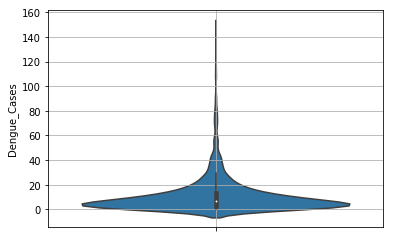

In [10]:
sns.violinplot(data=dengue_df, y='Dengue_Cases')
plt.grid()

In [11]:
dengue_features = dengue_one_hot.drop('Dengue_Cases', axis=1).astype(np.float64)
dengue_cases = dengue_one_hot.Dengue_Cases

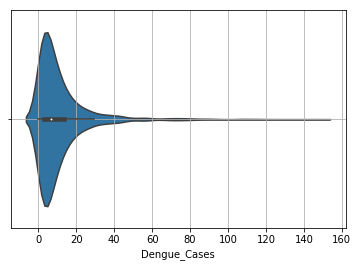

In [12]:
sns.violinplot(dengue_cases)
plt.grid()

In [13]:
dengue_target = pd.cut(dengue_cases, [-0.1, 3.0, 11.3, 45.0, 1e6], 
                       labels=[0, 1, 2, 3]).astype(np.float64)

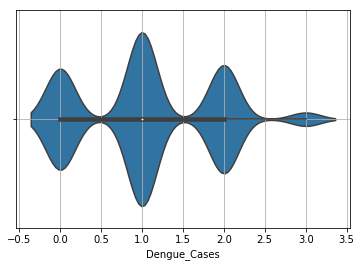

In [14]:
sns.violinplot(dengue_target)
plt.grid()

The smallest class in the data for the current split is 11.


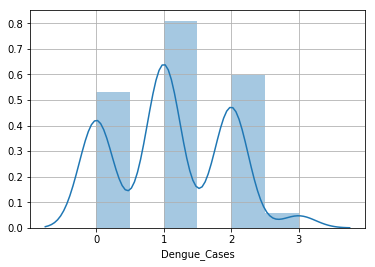

In [15]:
# checking the voracity of an 80/20 split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dengue_features, dengue_target, test_size=0.2)

test_plot = pd.concat([y_train, y_test], axis=1)
sns.distplot(y_test)
print('The smallest class in the data for the current split is {}.'.format(min([y_test[y_test == val].count() for val in y_test.unique()])))
plt.grid()

We will argue that an 80/20 split is inappropriate for the data at hand because class 3 has very few instances, which results in the test set getting very few, often fewer than ten, instances of that class, which is the most important for our use case. This is almost certainly not enough instances to get good information on how the model is performing with our most important data. Because of this, we will move to a 60/40 train/test split for the remainder of our analysis.

The smallest class in the data for the current split is 26.


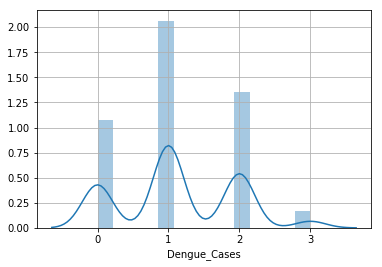

In [16]:
# adjusting size of test set
X_train, X_test, y_train, y_test = train_test_split(dengue_features, dengue_target, test_size=0.4)

test_plot = pd.concat([y_train, y_test], axis=1)
sns.distplot(y_test)
print('The smallest class in the data for the current split is {}.'.format(min([y_test[y_test == val].count() for val in y_test.unique()])))
plt.grid()

## Custom Logistic Regression Model

### Building the Model

Class Structure:
- BinaryLogisticRegressionBase
  - BinaryLogisticRegression
- Logistic Regression

LogisticRegression will instantiate $n$ Binary Regression Objects, where $n$ is the number of classes that we are distinguishing between.

The Binary Logistic Regression model will have options for setting l1- and l2-norm regularization, as well as an option for choosing optimization strategies (e.g. batch, SGD, BFGS).

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, mean_squared_error, roc_auc_score, confusion_matrix

### Binary Logistic Regression

In [18]:
from scipy.special import expit

class BinaryLogisticRegressionBase:
    
    '''Implements binary logistic regression for '''
    
    def __init__(self,
                alpha=0.1,
                threshold=0.5,
                iterations=500,
                C=0.1,
                reg='l2',
                tol=1e-3,
                solver='bfgs'
               ):
        self.alpha = np.float64(alpha)
        self.max_it = np.int(iterations)
        self.tol = np.float64(tol)
        self.C = np.float64(C)
        self.threshold = np.float64(threshold)
        
        if solver not in ['batch', 'sgd', 'bfgs', 'mse']:
            raise ValueError('That is not a valid value for solver.')
        else:
            self.solver = solver
        
        if reg not in ['l1', 'l2', 'l1_and_l2']:
            raise ValueError('That is not a valid value for reg.')
        else:
            self.reg = reg
        
    @staticmethod
    def _sigmoid(theta):
        return 1/(1 + np.exp(-theta))
    
    @staticmethod
    def _add_bias(X):
        return np.hstack([np.ones((X.shape[0], 1)), X])
    
    def _regularize(self):
        if self.reg == 'l1':
            return np.sum(self.w_/abs(self.w_))
            
        elif self.reg == 'l2':
            return 2 * np.sum(self.w_)
            
        elif self.reg == 'l1_and_l2':
            return np.sum(self.w_/abs(self.w_)) + 2 * np.sum(self.w_)
        else:
            raise ValueError('Somehow, this object has come to have a bad value for the \'reg\' attribute.')        

    def predict_proba(self, X, add_bias=True):
        return (expit(self._add_bias(X) @ self.w_) if add_bias else expit(X @ self.w_))
        
    def predict(self, X):
        return (self.predict_proba(X) > self.threshold).astype(np.int)

In [706]:
from scipy.optimize import fmin_bfgs
from numpy.linalg import pinv

class BinaryLogisticRegression(BinaryLogisticRegressionBase):

    def __init__(self,
                alpha=0.1,
                threshold=0.5,
                iterations=500,
                C=0.1,
                reg='l2',
                tol=1e-3,
                solver='bfgs'
               ):
        super().__init__(
            alpha=alpha,
            threshold=threshold,
            iterations=iterations,
            C=C,
            reg=reg,
            tol=tol,
            solver=solver
        )
        
    @staticmethod
    def bfgs_grad(w,D,y,C):
        return -(np.mean(D * (y - expit(D @ w))[:,np.newaxis], axis=0) - 2 * w * C)
    
    @staticmethod
    def bfgs_obj(w,D,y,C):
        return -np.sum(np.log(expit(D @ w)[y==1])) - np.sum(1 - np.log(expit(D @ w)[y==0])) + C * np.sum(w**2)
    
    @staticmethod
    def mse_obj(w,D,y,C):
        g = expit(D @ w)
        return np.sum((y - g)**2)
    
    @staticmethod
    def mse_grad(w,D,y,C):
        g = expit(D @ w)
        return np.sum(D * 2 * (-g**3 + (1 + y) * g**2 - y * g)[:,np.newaxis], axis=0) - 2 * w * C
    
    def _mse_newton(self,w,D,y,C):
        g = expit(D @ w) # get sigmoid value for all classes
        hessian = self._mse_hess(w,D,y,C) # calculate the hessian
        gradient = self.mse_grad(w,D,y,C)
        
        gradient = gradient.reshape(w.shape)
        gradient[1:] += -2 * w[1:] * C
        
        return pinv(hessian) @ gradient

    
    def _mse_hess(self,w,D,y,C):
        g = expit(D @ w)
        return D.T @ np.diag(6 * g**4 - 10 * g**3 - 4*y * g**3 + 4 * g**2 + 6*y * g**2 - 2*y * g) @ D - 2 * C
        

    def _gradient(self, X, y):
        if self.solver == 'batch':
            return np.mean(X * (y - self.predict_proba(X, add_bias=False))[:,np.newaxis], axis=0) - self.C * self._regularize()
        
        elif self.solver == 'sgd':
            idx = np.random.choice(X.shape[0])
            return (y[idx] - self.predict_proba(X[idx,:], add_bias=False)) * X[idx,:] - self.C * self._regularize()
        
        elif self.solver == 'mse':
            return self._mse_newton(self.w_, X, y, self.C)

        else:
            return ValueError('The value for the \'solver\' attribute is something it should not be.')
    

    def fit(self, X, y):
        Xfit = self._add_bias(X)
        self.w_ = np.random.rand(Xfit.shape[1], 1).ravel()

        if self.solver == 'bfgs':
            self.w_ = fmin_bfgs(BinaryLogisticRegression.bfgs_obj,
                                np.random.rand(Xfit.shape[1], 1),
                                fprime=BinaryLogisticRegression.bfgs_grad,
                                args=(Xfit, y, self.C),
                                gtol=self.tol,
                                maxiter=self.max_it,
                                disp=False)
        
#         elif self.solver == 'mse':
#             self.w_ = fmin_bfgs(self.mse_obj,
#                                 np.random.rand(Xfit.shape[1], 1),
#                                 fprime=self.mse_grad,
#                                 args=(Xfit, y, self.C),
#                                 gtol=self.tol,
#                                 maxiter=self.max_it,
#                                 disp=False)            

        else:
            for i in range(self.max_it):
                grad = self._gradient(Xfit, y)
                self.w_ += self.alpha * grad.ravel()
                if np.mean(abs(grad)) <= self.tol:
#                     print('Broke out with {}'.format(np.mean(abs(grad))))
                    break

In [496]:
# %%time

from sklearn.preprocessing import StandardScaler

dengue_bin = (dengue_target <= 2).astype(bool)

# preliminary test of the model
dengue_predict = StandardScaler().fit_transform(dengue_features)
blr = BinaryLogisticRegression(alpha=0.1, iterations=3, solver='mse', reg='l2', C=0.1)
%time blr.fit(dengue_predict, dengue_bin)
print(f1_score(dengue_bin, blr.predict(dengue_predict)))

CPU times: user 179 ms, sys: 166 ms, total: 345 ms
Wall time: 122 ms
0.6604616530156365


In [588]:
class LogisticRegression:
    
    def __init__(self,
                alpha=0.1,
                threshold=0.5,
                iterations=500,
                C=0.1,
                reg='l2',
                tol=1e-3,
                solver='bfgs',
                 class_weight=np.array([1,1,1,1]) #allow for manually shifting prediction to favor certain classes
               ):
        self.alpha = np.float64(alpha)
        self.max_it = np.int(iterations)
        self.tol = np.float64(tol)
        self.C = np.float64(C)
        self.threshold = np.float64(threshold)
        self.reg = reg
        self.solver = solver
        self.class_weight = class_weight
        
    def fit(self, X, y):
        self.models_ = []
        for i in np.unique(y):
            blr = BinaryLogisticRegression(alpha=self.alpha,
                                           threshold=self.threshold,
                                           solver=self.solver,
                                           iterations=self.max_it,
                                           C=self.C,
                                           reg=self.reg,
                                           tol=self.tol
                                          )
            blr.fit(X, y==i)
            self.models_.append(blr)            
        
    def predict_proba(self, X):
        probs = []
        for pred, weight in zip(self.models_, self.class_weight):
            probs.append(pred.predict_proba(X).T)
            
        return np.vstack(probs)
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=0).T

## Optimizing the Model

### A Brief aside to Construct a Metric

As mentioned previously in our understanding and applications of the data, we care more about correctly predicting time points at which the disease is particularly bad than about predicting it when it's less bad. let's see about constructing a metric that gives us just that.

In [23]:
from sklearn.utils.class_weight import compute_class_weight

cw = compute_class_weight('balanced', dengue_target.unique(), dengue_target)
print('Default class weights are: {}'.format(cw))

Default class weights are: [0.98076923 0.57018634 0.91616766 7.40322581]


The above class weights are designed to balance the classes and make sure that one is not favored over the other. The formula looks like $$\frac{n\_samples}{n\_classes * np.bincount(y)}$$

However, we actually do want the classes to be skewed, so let's add some more weight to the severe classes and take a little away from the less severe cases.

In [24]:
cw_custom = compute_class_weight({0:0.5, 1:0.5, 2:3, 3:20}, dengue_target.unique(), dengue_target)
print('Custom class weights are: {}'.format(cw_custom))

Custom class weights are: [ 0.5  0.5  3.  20. ]


Now, let's go about defining a metric that will behave according to our intended use case. These weights are good, but we probably need something with a finer-toothed comb. 

For the purposes of this classification task, we care much more about misclassifying instances to lower-severity classes, and much less about "up-classifying." We can pick these different misclassifications apart using the confusion matrix of the data and multiplying it element-wise by a matrix of weights.

The downside of this approach is that it is hard to interpret for "literature" purposes, so once the model has been optimiized, we will also have to translated that to an accuracy or f-beta score.

In [642]:
def weighted_score(y_true, y_pred):
    conf = confusion_matrix(y_true, y_pred)
    weights = np.array([[0, 0.5, 0.5, 0.5],
                        [0.9, 0, 0.5, 0.5],
                        [5, 2, 0, 0.5],
                        [30, 20, 10, 0]])
    conf_tot = np.sum(conf, axis=0)
    conf_tot[conf_tot == 0] = 1
    return np.sum((conf/conf_tot) * weights)

### Preliminary Tests of the Classifier

In [673]:
%%time

#preliminary test of logistic regression, batch

log_reg = LogisticRegression(alpha=0.01, iterations=300, solver='batch', reg='l2', C=0.1, class_weight=cw_custom)
log_reg.fit(dengue_predict, dengue_target)
print(weighted_score(dengue_target, log_reg.predict(dengue_predict)))

4.151222814124716
CPU times: user 910 ms, sys: 1.78 s, total: 2.69 s
Wall time: 740 ms


In [676]:
%%time

#preliminary test of logistic regression, mse

log_reg = LogisticRegression(alpha=0.01, iterations=1, solver='mse', reg='l2', C=0.1)
log_reg.fit(dengue_predict, dengue_target)
print(weighted_score(dengue_target, log_reg.predict(dengue_predict)))

6.627411594196747
CPU times: user 238 ms, sys: 120 ms, total: 358 ms
Wall time: 125 ms


In [712]:
%%time

#preliminary test of logistic regression, stochastic

log_reg = LogisticRegression(alpha=0.2, iterations=800, solver='sgd', reg='l2', C=0.1)
log_reg.fit(dengue_predict, dengue_target)
print(weighted_score(dengue_target, log_reg.predict(dengue_predict)))

4.742125307210868
CPU times: user 172 ms, sys: 12.6 ms, total: 185 ms
Wall time: 172 ms


In [736]:
%%time

#preliminary test of logistic regression, bfgs

log_reg = LogisticRegression(alpha=0.01, iterations=2, solver='bfgs', reg='l2', C=0.1, class_weight=cw_custom)
# log_reg = LogisticRegression(alpha=bfgs_alpha, iterations=bfgs_iterations, solver='bfgs', reg='l2', C=bfgs_C)
log_reg.fit(dengue_predict, dengue_target)
print(weighted_score(dengue_target, log_reg.predict(dengue_predict)))

2.2833473653775136
CPU times: user 170 ms, sys: 255 ms, total: 426 ms
Wall time: 157 ms


### Optimizing Hyperparameters

Now, we have a working logistic regression model, which is performing fairly well on the data at hand with hyperparameters which are, for the most part, shots in the dark. Now, let's see if we can optimize some of these parameters. 

First, we'll try a somewhat naive grid search model. Scikit-learn has a nice API for this, but we'll do it by hand to make visualization easier. 

Also for now, we will make the almost-certainly-false assumption that each parameter's maximum is independent of the values of the other parameters.

SGD and BFGS both clearly outperformed batch descent in the preliminary trials, so we'll restrict ourselves to those two here.

In [626]:
import warnings
import time

warnings.filterwarnings("ignore")

def optimize_param(X_train, X_test, y_train, y_test, predictor, param, vals, kwargs, scores_return=False):
    scores = []
    times = []
    best_param = 0
    best_score = np.inf
    
    kwargs.update({param:0})
    for val in vals:
        kwargs[param] = val
        pred = predictor(**kwargs)
        start = time.time()
        pred.fit(X_train, y_train)
        times.append(time.time() - start)
        pred_score = weighted_score(y_test, pred.predict(X_test))
        scores.append(pred_score)
        if pred_score < best_score and not np.isnan(pred_score):
            best_param = val
            best_score = pred_score
            
    if scores_return:
        return best_param, scores, times
    else:
        fig, ax = plt.subplots()

        print('Best score achieved on this round of training runs with {} == {} '.format(param, best_param))
        ax.plot(vals, scores / np.mean(scores), 'g--', label='normalized scores')
        ax.plot(vals, times / np.mean(times), 'b-.', label='normalized time')
        ax.scatter(best_param, best_score / np.mean(scores), c='r', label='optimal score')
        ax.set_title('Scores and Times for Different Values of {}, {}'.format(param, pred.solver))
        ax.legend(loc='best')
        ax.grid()
        return best_param

Let's go ahead and split up our training and testing sets as discussed previously.

In [437]:
dengue_X_train, dengue_X_test, dengue_y_train, dengue_y_test = train_test_split(dengue_predict, dengue_target, test_size=0.4)

dengue_y_train = dengue_y_train.ravel()
dengue_y_test = dengue_y_test.ravel()

Best score achieved on this round of training runs with iterations == 46 


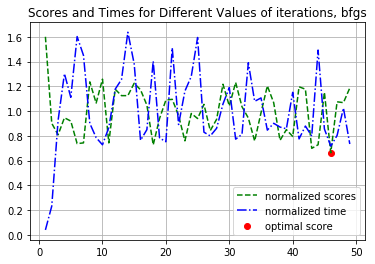

In [758]:
# dengue_X_train, dengue_X_test, dengue_y_train, dengue_y_test = train_test_split(dengue_predict, dengue_target, test_size=0.4)
dengue_X_train, dengue_X_test, dengue_y_train, dengue_y_test = train_test_split(dengue_predict, dengue_target, test_size=0.4)

dengue_y_train = dengue_y_train.ravel()
dengue_y_test = dengue_y_test.ravel()

bfgs_its = optimize_param(dengue_X_train, dengue_X_test, dengue_y_train, dengue_y_test, LogisticRegression, 'iterations', np.arange(1, 50, 1), {'solver' : 'bfgs'})

Now, due to time concerns, we will actually not select the number of iterations that gave us the best score because it takes much longer on average than smaller numbers of iterations. Instead, we will go for a value just before the increase in time, say 3.

In [207]:
bfgs_iterations = 3

Best score achieved on this round of training runs with iterations == 2650 


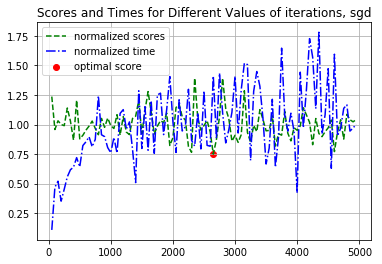

In [759]:
dengue_X_train, dengue_X_test, dengue_y_train, dengue_y_test = train_test_split(dengue_predict, dengue_target, test_size=0.4)

dengue_y_train = dengue_y_train.ravel()
dengue_y_test = dengue_y_test.ravel()

sgd_its = optimize_param(dengue_X_train, dengue_X_test, dengue_y_train, dengue_y_test, LogisticRegression, 'iterations', np.arange(50, 5000, 50), {'solver' : 'sgd'})

Again, we won't pick exactly the maximum, but the point at which both the score and the time overlap in being stable is a fairly good choice. Looking at the graph, this appears to happen around 800, which will be our choice.

In [208]:
sgd_iterations = 800

Best score achieved on this round of training runs with alpha == 0.395 


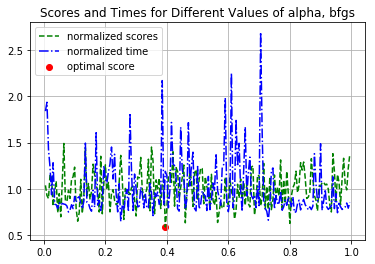

In [760]:
dengue_X_train, dengue_X_test, dengue_y_train, dengue_y_test = train_test_split(dengue_predict, dengue_target, test_size=0.4)

dengue_y_train = dengue_y_train.ravel()
dengue_y_test = dengue_y_test.ravel()

bfgs_a = optimize_param(dengue_X_train, dengue_X_test, dengue_y_train, dengue_y_test, LogisticRegression, 'alpha', np.arange(0.005, 1, 0.005), {'solver' : 'bfgs', 'iterations' : bfgs_iterations})

Here we can really see how the scores destabilize for large values of alpha. Again, we would like alpha to be small, so that the model trains well, but large enough so that it doesn't take more time than necessary. The plot indicates that this happens around 0.3.

In [445]:
bfgs_alpha = 0.4

Best score achieved on this round of training runs with alpha == 0.3 


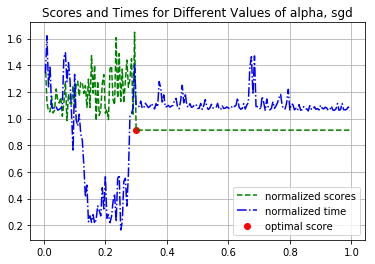

In [761]:
dengue_X_train, dengue_X_test, dengue_y_train, dengue_y_test = train_test_split(dengue_predict, dengue_target, test_size=0.4)

dengue_y_train = dengue_y_train.ravel()
dengue_y_test = dengue_y_test.ravel()

sgd_a = optimize_param(dengue_X_train, dengue_X_test, dengue_y_train, dengue_y_test, LogisticRegression, 'alpha', np.arange(0.005, 1, 0.005), {'solver' : 'sgd', 'iterations' : sgd_iterations})

This plot just looks somewhat bizarre. However, it looks like there may be a window of relative stability in both training time and score around $\alpha = 0.05$.

In [704]:
sgd_alpha = 0.01

In our model, $C$ is a regularization parameter, so it trades off underfitting the data slightly for overfitting it. So, to account for this, we will pull a trick where we have the model predict on the training set to see how much it is underfitting, and it will also test on the cross-validation set to see how it is overfitting. Additionally, it is unclear if we should optimize for which type of regularization we need or what exactly that would mean, so we will leave that as an option but stick to the default $L^2$ norm.

In [448]:
def underfit_overfit(X_train, X_test, y_train, y_test, predictor, param, vals, kwargs):
    _, scores_cv, times_cv = optimize_param(X_train, X_test, y_train, y_test, predictor, param, vals, kwargs, scores_return=True)
    _, scores_train, times_train = optimize_param(X_train, X_train, y_train, y_train, predictor, param, vals, kwargs, scores_return=True)
    scores_mean = np.mean(scores_train + scores_cv)
    
    fig, ax = plt.subplots()
    
    ax.plot(vals, scores_train / scores_mean, 'g--', label='normalized training scores')
    ax.plot(vals, scores_cv / scores_mean, 'c:', label='normalized cv scores')

    ax.set_title('Scores and Times for Different Values of {}, {}'.format(param, kwargs['solver']))
    ax.legend(loc='best')
    ax.grid()

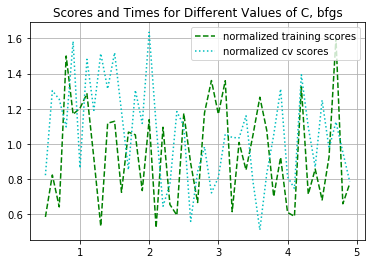

In [762]:
dengue_X_train, dengue_X_test, dengue_y_train, dengue_y_test = train_test_split(dengue_predict, dengue_target, test_size=0.4)

dengue_y_train = dengue_y_train.ravel()
dengue_y_test = dengue_y_test.ravel()

underfit_overfit(dengue_X_train, dengue_X_test, dengue_y_train, dengue_y_test, LogisticRegression, 'C', np.arange(0.5, 5, 0.1), {'solver' : 'bfgs', 'iterations' : bfgs_iterations, 'alpha' : bfgs_alpha})

It's a little difficult to tell, but our golden value, where the bias and variance appear to cross somewhat meaningfully, looks to be around $C=2.5$

In [237]:
bfgs_C = 2.5

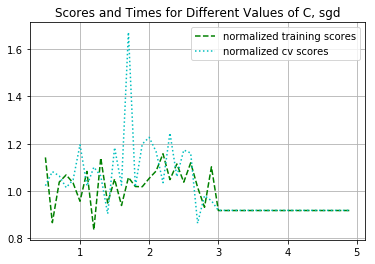

In [763]:
dengue_X_train, dengue_X_test, dengue_y_train, dengue_y_test = train_test_split(dengue_predict, dengue_target, test_size=0.4)

dengue_y_train = dengue_y_train.ravel()
dengue_y_test = dengue_y_test.ravel()

underfit_overfit(dengue_X_train, dengue_X_test, dengue_y_train, dengue_y_test, LogisticRegression, 'C', np.arange(0.5, 5, 0.1), {'solver' : 'sgd', 'iterations' : 1000, 'alpha' : 0.01})

It appears as though SGD completely dies for larger values of $C$. The plot is inconclusive, but the scores appear to cross in a somewhat meaningful way around $C=2$, which will be our choice.

In [461]:
sgd_C = 2

Obviously, there are other parameters to the LogisticRegression class, but none that are particularly relevant to the actual model fit, so for now, we will consider the task of optimizing hyperparameters to be complete.

It is perhaps at this point that we should start to discuss the topic of data snooping. In a reasonable predictive modelling setup, we really ought to have a couple hard splits. We should have one test set which is set aside and not touched except to evaluate overall model performance. The remaining training set should then be split up a number of times and each hyperparameter tuned using these so-called cross-validation folds. Once the hyperparameters are optimized to the cross-validation folds, the model should be tested on the the test set which was set aside earlier. This is to avoid the problem of overfitting hyperparameters to the data at hand and keeping the model as general as possible.

Clearly, this is not what we have done here. We have taken the simple approach and simply optimized our hyperparameters to the whole training set, likely overfitting the model. This constitutes data snooping, and we are indeed guilty of it.

Now, let's see which our models classifies better, faster and whether or not it holds up to our baseline.

### Examining Performance of Best Classifier

First, let's get the better of the two classifiers.

In [812]:
bfgs_times = []
bfgs_scores = []

dengue_X_train, dengue_X_test, dengue_y_train, dengue_y_test = train_test_split(dengue_predict, dengue_target, test_size=0.4)

dengue_y_train = dengue_y_train.ravel()
dengue_y_test = dengue_y_test.ravel()

for i in range(20):
    pred = LogisticRegression(solver='bfgs', 
                              C=bfgs_C, 
                              alpha=bfgs_alpha,
                              iterations=bfgs_iterations
                             )
    start = time.time()
    pred.fit(dengue_X_train, dengue_y_train)
    bfgs_times.append(time.time() - start)
    bfgs_scores.append(weighted_score(dengue_y_test, pred.predict(dengue_X_test)))
    
score_mean = np.mean(bfgs_scores)
time_mean = np.mean(bfgs_times)
print('Our implementation of BFGS classification achieves a score of {:.4f} in {:.4f} seconds'.format(score_mean, time_mean))

Our implementation of BFGS classification achieves a score of 4.5718 in 0.1563 seconds


In [814]:
sgd_times = []
sgd_scores = []

dengue_X_train, dengue_X_test, dengue_y_train, dengue_y_test = train_test_split(dengue_predict, dengue_target, test_size=0.4)

dengue_y_train = dengue_y_train.ravel()
dengue_y_test = dengue_y_test.ravel()

for i in range(20):
    pred = LogisticRegression(solver='sgd', 
                              reg='l2', 
                              C=sgd_C, 
                              alpha=sgd_alpha,
                              iterations=sgd_iterations
                             )
    start = time.time()
    pred.fit(dengue_X_train, dengue_y_train)
    sgd_times.append(time.time() - start)
    sgd_scores.append(weighted_score(dengue_y_test, pred.predict(dengue_X_test)))
    
score_mean = np.mean(sgd_scores)
time_mean = np.mean(sgd_times)
print('Our implementation of SGD classification achieves a score of {:.4f} in {:.4f} seconds'.format(score_mean, time_mean))

Our implementation of SGD classification achieves a score of 3.0418 in 0.1419 seconds


The best we can do appears to be stochastic gradient descent, which achieves about $3.04$ with our custom-built metric and trains in about $142$ms. Let's see how this performs with respect to the baseline of just predicting last month's severity.

In [799]:
start = time.time()
baseline = np.roll(dengue_target, 1)
baseline_score = weighted_score(dengue_target, baseline)
baseline_time = time.time() - start

print('The baseline gives us a score of {}'.format(baseline_score))

The baseline gives us a score of 3.0158991286931762


Admittedly, having spent my past two weeks working on this, seeing that the baseline actually predicts the next month this well is really demoralizing. The proposed model actually might not bring that much value to the table.

Now, let's compare our best to scikit-learn, and then we'll visualizee performance a bit.

## Comparing to Scikit-Learn

 Scikit-learn implements logistic regression using the liblinear algorithm, which is extremely well-optimized for solving logistic regression. It is finely tuned and will be difficult to beat.

In [823]:
from sklearn.linear_model import LogisticRegression as SKLR

sklr_times = []
sklr_scores = []

dengue_X_train, dengue_X_test, dengue_y_train, dengue_y_test = train_test_split(dengue_predict, dengue_target, test_size=0.4)

dengue_y_train = dengue_y_train.ravel()
dengue_y_test = dengue_y_test.ravel()

for i in range(20):
    # we won't even bother optimizing hyperparameters
    pred = SKLR()
    start = time.time()
    pred.fit(dengue_X_train, dengue_y_train)
    sklr_times.append(time.time() - start)
    sklr_scores.append(weighted_score(dengue_y_test, pred.predict(dengue_X_test)))
    
    
score_mean = np.mean(sklr_scores)
time_mean = np.mean(sklr_times)
print('Scikit-learn\'s implementation of logistic regression achieves a score of {:.4f} in {:.4f} seconds'.format(score_mean, time_mean))

Scikit-learn's implementation of logistic regression achieves a score of 3.4922 in 0.0172 seconds


**Out, out, brief candle! Life's but a walking shadow, a poor player that struts and frets his hour upon the stage and then is heard no more: it is a tale told by an idiot, full of sound and fury, signifying nothing.**

-Macbeth, Act V, Scene V

## Post-Mortem

In [825]:
from sklearn.linear_model import LogisticRegression as SKLR

best_times = []
best_scores = []

for i in range(20):
    # we won't even bother optimizing hyperparameters
    pred = SKLR()
    start = time.time()
    pred.fit(dengue_X_train, dengue_y_train)
    best_times.append(time.time() - start)
    best_scores.append(f1_score(dengue_y_test, pred.predict(dengue_X_test), average='weighted'))
    
    
score_mean = np.mean(best_scores)
time_mean = np.mean(best_times)
print('Scikit-learn\'s implementation of logistic regression achieves an f1-score of {:.4f} in {:.4f} seconds'.format(score_mean, time_mean))

Scikit-learn's implementation of logistic regression achieves an f1-score of 0.5172 in 0.0175 seconds


Well, we perform slightly better on the given metric than sklearn does, but it classifies in about an order of magnitude less time. It is definitely the superior classification algorithm and almost certainly should be used over our implementation for any classification task. Scikit-learn gives us an f1-score of around $0.52$ on the data, which is what we would likely report to the Philippine DOH if we could get them to listen.

However, it should still be noted that this is not great and, in fact, does not even beat the baseline. Let's take a look at just how not great this is.

In [826]:
num_repetitions=len(bfgs_scores)

bfgs_df = pd.DataFrame({
    'classifier': ['bfgs'] * num_repetitions,
    'time': bfgs_times,
    'score': bfgs_scores
})

sgd_df = pd.DataFrame({
    'classifier': ['sgd'] * num_repetitions,
    'time': sgd_times,
    'score': sgd_scores
})

sklr_df = pd.DataFrame({
    'classifier': ['sklr'] * num_repetitions,
    'time': sklr_times,
    'score': sklr_scores
})

baseline_df = pd.DataFrame({
    'classifier': ['dumb'] * num_repetitions,
    'time': [0] * num_repetitions,
    'score': [baseline_score] * num_repetitions
})

performance_df = pd.concat([bfgs_df, sgd_df, sklr_df, baseline_df])

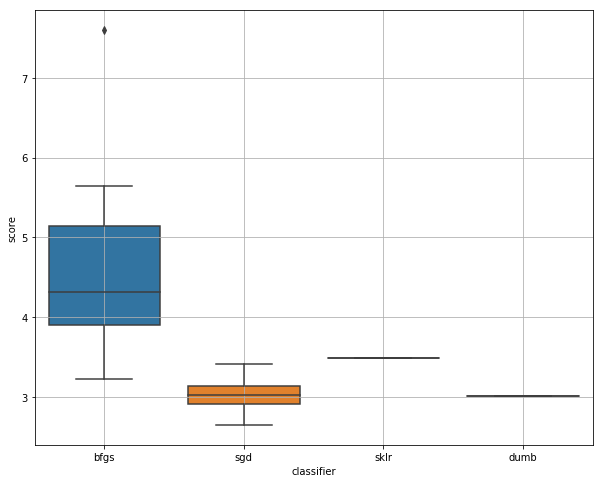

In [827]:
sns.boxplot(data=performance_df, x='classifier', y='score')
plt.grid()

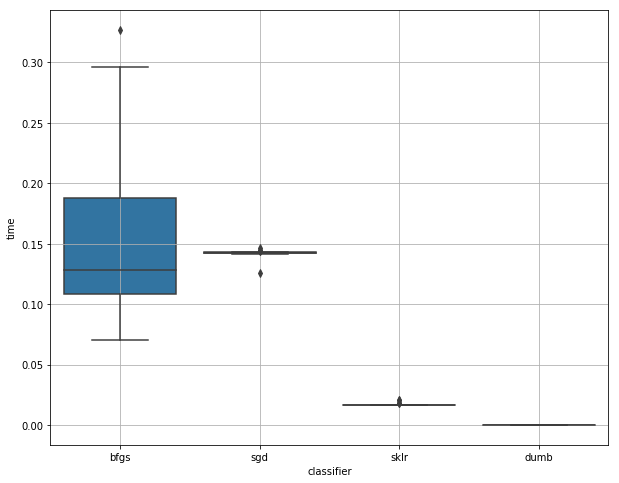

In [828]:
sns.boxplot(data=performance_df, x='classifier', y='time')
plt.grid()

Well, it may simply be the case that using logistic regression to predict the incidence of dengue fever in the Philippines by month is simply not a feasible task. The best we can do is to almost meet the baseline, and the baseline takes effectively no computational resources to compute. 

If someone were looking to use logistic regression to predict how severe this disease would be in a coming period of time, we would recommend that they not. However, if they insisted, we would recommend that they use the scikit-learn implementation of logistic regression.